# 02 Machine Learning / Proyecto

## Credit Card Leads

### Equipo:
- Javier De La Rosa Mondragon
- Luis Fernando Merino Nambo
- Salomon Ramírez

![Leads](credit-cards.jpg)

##  Dataset

Credit Card Lead Prediction

https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers

- ~250,000 filas en train set

- ~100,000 etiquetas en test set

- 10 Features
    - ID
    - Sexo
    - Edad
    - Region
    - Ocupación
    - Channel code
    - Vintage
    - Credit product
    - Balance promedio
    - Activo
    


- 1 Columna de target
    - Lead

## Objetivo

Analizar, limpiar y usar el train dataset para identificar clientes con tendencia a adquirur una tarjeta de crédito tomando como features los datos del cliente y los productos con los que ya cuentan.


## Importación de bibliotecas 

In [55]:
# VARIABLES DE EJECUCIÓN
DATA_FRACTION =.8
LONG_TIME_CELLS = True

In [2]:
# numerical y Dfs
import pandas as pd
import numpy as np

# ML:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 # selección de features categoricas
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV

# SMOTE oversamplig
from imblearn.over_sampling import SMOTE

# árboles de decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# visualización de árboles con dtreeviz
from sklearn import tree
#from dtreeviz import model
from dtreeviz.trees import *

# visualización de árboles con graphviz
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# métricas de rendimiento
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# visualización
import seaborn as sns
from matplotlib import pyplot as plt

# timing operations
import time

In [3]:
# paletas para seaborn
palQualitative = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palPaired = sns.color_palette("Accent")
sns.set()
sns.set_palette( palQualitative )

## Lectura de datos

In [4]:
data = pd.read_csv('./data/train data credit card.csv')
print('Full Data size:',data.shape)

Full Data size: (245725, 11)


In [5]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


## Limpieza y EDA

In [6]:
display(data.isna().sum())
print(data.shape)

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

(245725, 11)


In [7]:
# limpieza de datos del set de entrenamiento
# ya que el dataset es muy grande, empezaremos eliminando las filas con datos vaciós
data = data.dropna()
data.reset_index(inplace=True,drop=True)
display(data.isna().sum().sum())
print(data.shape)

0

(216400, 11)


In [8]:
def create_piechart_with_values(data, title, ax, optional_names=None):
    df = data
    value_counts = df.value_counts()
    category_counts = df.value_counts().values
    patches, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')

    total = sum(value_counts.values)
    label_values = []
    if optional_names:
        value_counts.index = optional_names
        
    for n,v in zip(value_counts.index,value_counts.values):
        v = f'{v:,}'
        #label_values.append(    f'{n}: {v} ({(v / total) * 100:.1f}%)'    )
        label_values.append(    f'{n}: {v}'    )
    
    for i, text in enumerate(texts):
        text.set_text(label_values[i])
    
    ax.set_title(title)

### Variables Categóricas

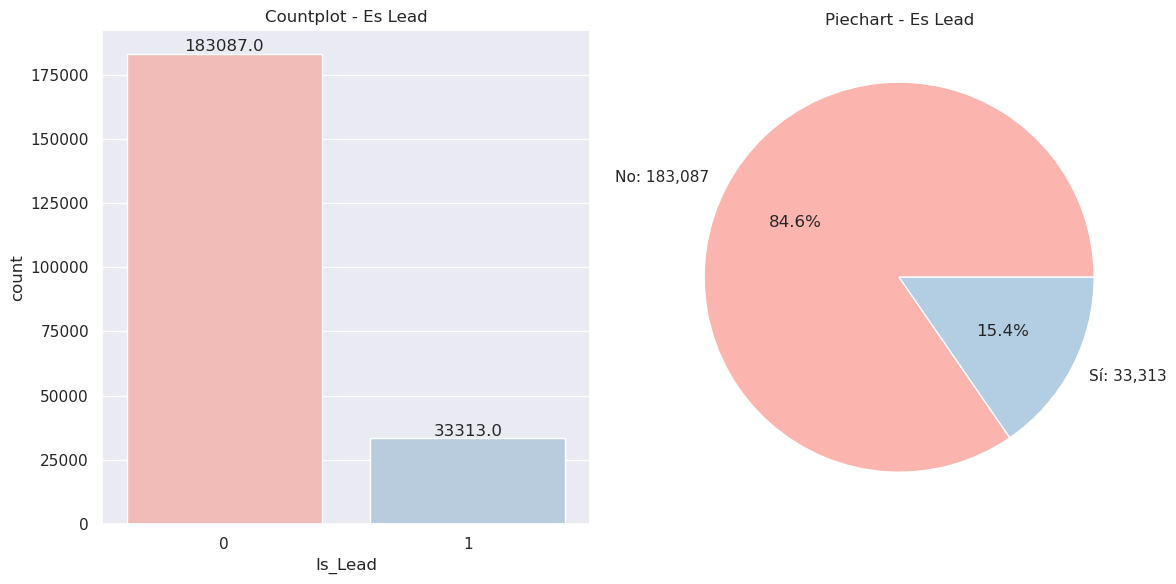

In [9]:
# ya que trabajaremos con clasificación, veamos cuántos casos hay de cada categoría:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x=data.Is_Lead, ax=ax1)
ax1.set_title('Countplot - Es Lead')

for p in ax1.patches:
    ax1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

create_piechart_with_values(data.Is_Lead, 'Piechart - Es Lead',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()


In [10]:
# Observamos que hay una deproporción muy grande.

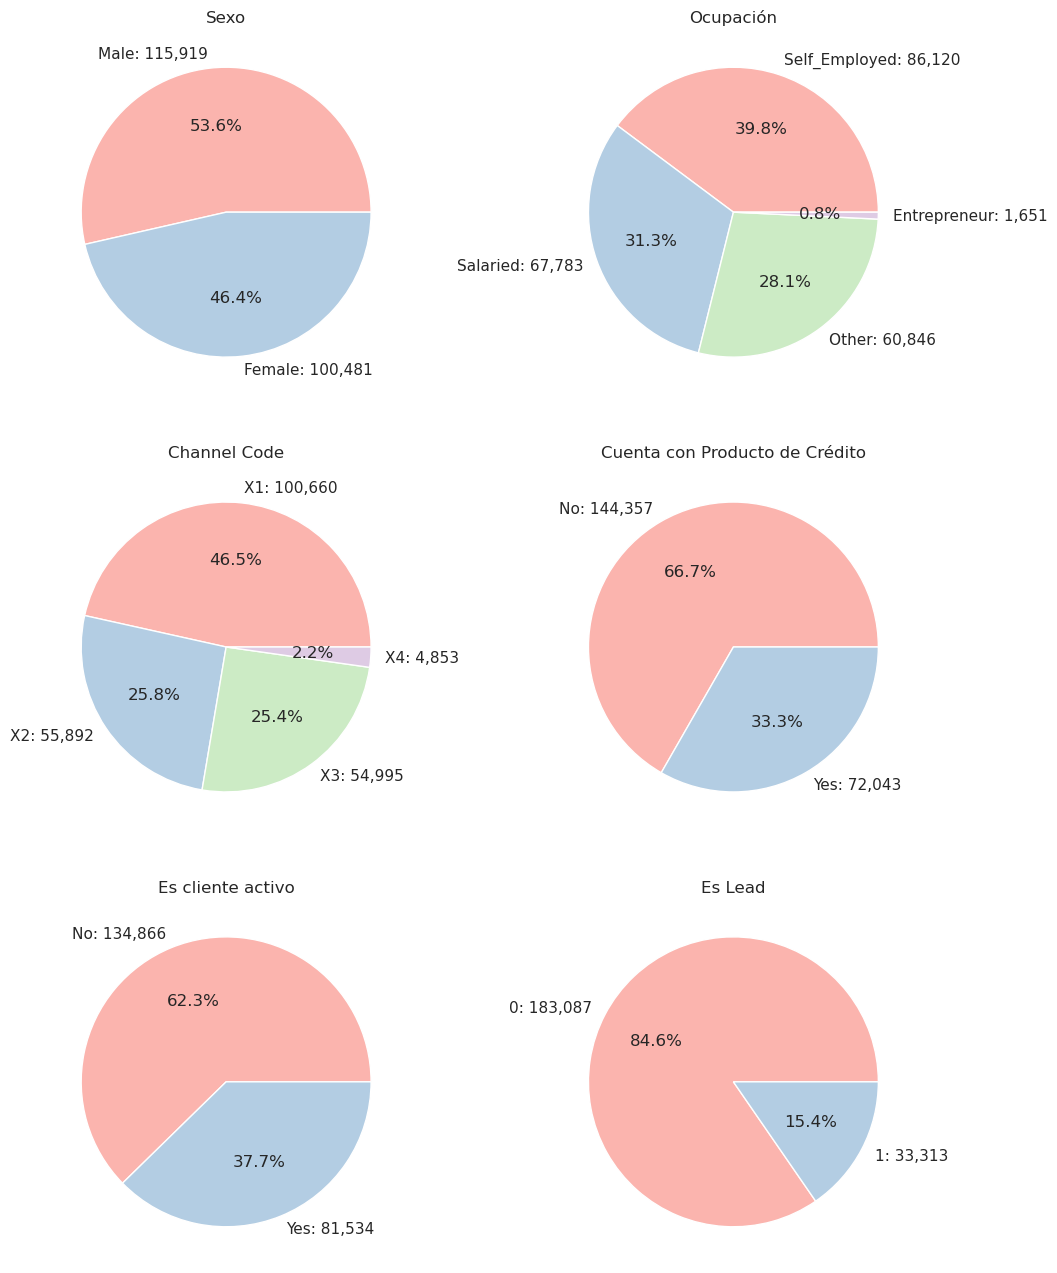

In [11]:
# Veamos las distribuciones de algunas variables:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

#sns.countplot(data=creditCardLeadDf, x='Gender', ax=axes[0])
#axes[0].set_title('Sexo')
#sns.countplot(data=creditCardLeadDf, x='Is_Active', ax=axes[0])
#axes[0].set_title('Es cliente activo')
#sns.countplot(data=creditCardLeadDf, x='Credit_Product', ax=axes[1])
#axes[1].set_title('Cuenta con Producto de Crédito')
#sns.countplot(data=creditCardLeadDf, x='Occupation', ax=axes[1])
#axes[1].set_title('Ocupación')

create_piechart_with_values(data.Gender, 'Sexo',axes[0][0])
create_piechart_with_values(data.Occupation, 'Ocupación',axes[0][1])
create_piechart_with_values(data.Channel_Code, 'Channel Code',axes[1][0])
create_piechart_with_values(data.Credit_Product, 'Cuenta con Producto de Crédito',axes[1][1])
create_piechart_with_values(data.Is_Active, 'Es cliente activo',axes[2][0])
create_piechart_with_values(data.Is_Lead, 'Es Lead',axes[2][1])

#plt.tight_layout()
plt.show()

Hay 35 valores distintos de Region_Code


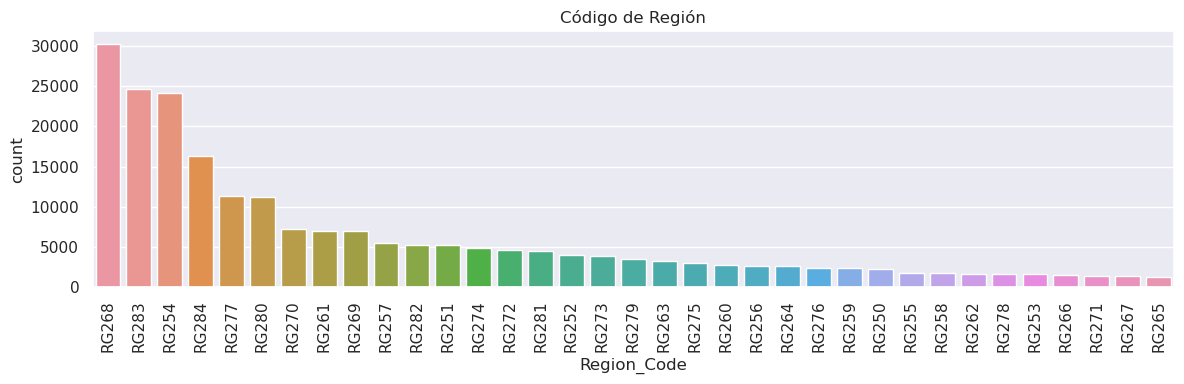

In [12]:
# Veamos las proporciones en algunas variables:
print('Hay',data.Region_Code.value_counts().shape[0],'valores distintos de Region_Code')

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(data=data.sort_values(by='Region_Code'), x='Region_Code', ax=axes, order = data['Region_Code'].value_counts().index)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set_title('Código de Región')
plt.tight_layout()

# Show the plot
plt.show()

Veremos más adelante si esta variable es relevante para la clasificación


### Variables Numéricas

Veamos histogramas y boxplots para las dos variables numéricas que tienen nuestros datos

In [13]:
def createHist(data,titulo,nobins=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 4))
    #data = creditCardLeadDf['Avg_Account_Balance']
    #titulo = 'Balance Promedio'

    if nobins:
        sns.histplot(data,ax=axes[0],bins= (data.max()-data.min()) )
    else:
        sns.histplot(data,ax=axes[0] )
    axes[0].set_xlabel('Values')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(titulo+' - Histograma')

    sns.boxplot(x=data, ax=axes[1])
    mean_value = np.mean(data)
    axes[1].plot(mean_value, 0,  marker='o', color='red', label='Mean')
    axes[1].text(mean_value+mean_value/1.5, -.3, f"Mean: {mean_value:.2f}", color='teal', ha='left', va='center')
    #axes[1].set_xlabel('Values')
    #axes[1].set_ylabel('Count')
    axes[1].set_title(titulo+' - Boxplot')
    #axes[1].legend()


    plt.tight_layout()
    plt.show()


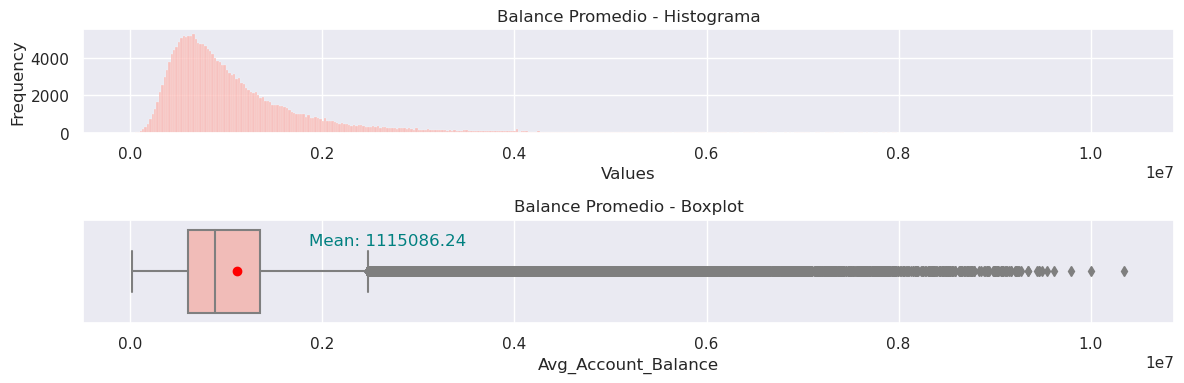

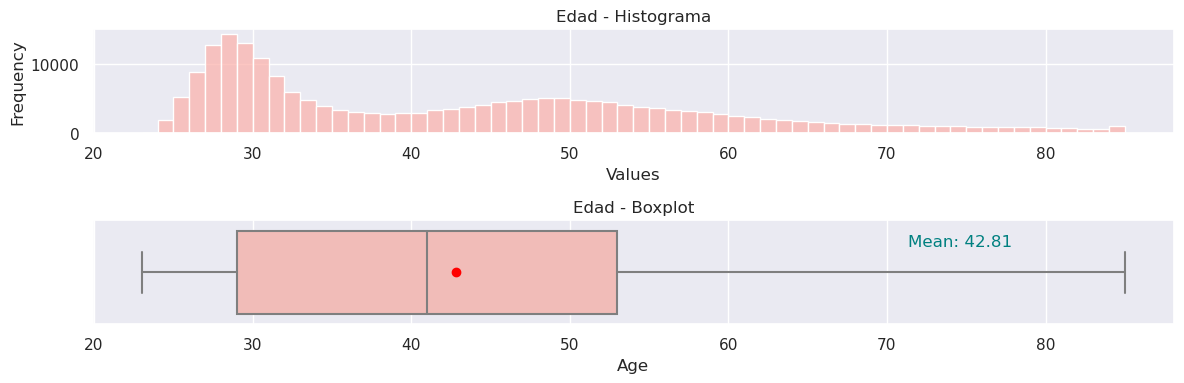

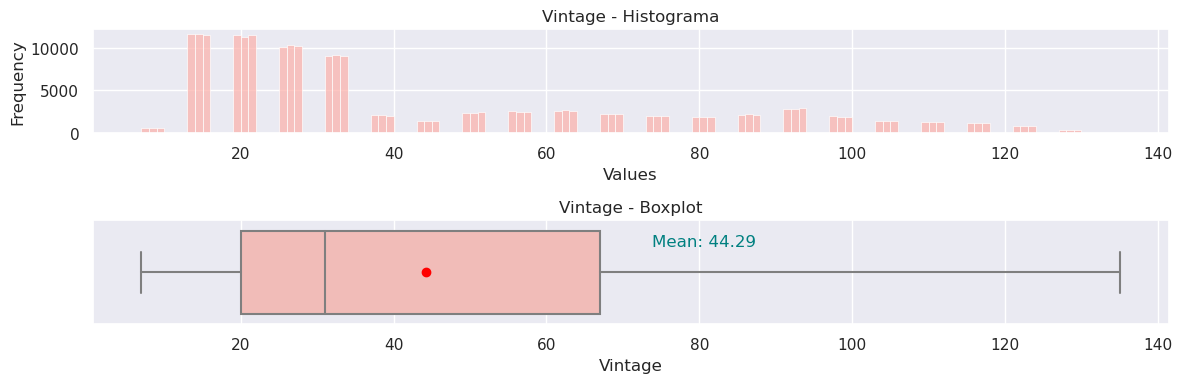

In [14]:
#sns.set_palette( palQualitative )
createHist(data['Avg_Account_Balance'],'Balance Promedio')
createHist(data['Age'],'Edad',nobins=True)
createHist(data['Vintage'],'Vintage',nobins=True)

In [15]:
# ya que la columna ID no aporta nada a la clasificación, la eliminaremos
data = data.drop('ID', axis=1)

In [16]:
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


### Conversión de variables a one-hot encoding

In [17]:
# las siguientes columnas puedes ser codificadas como one-hot:
# Gender (2 valores), Region_Code (35), Occupation (4), Channel_Code (4), Credit_Product (2), Is_Active (2)

In [18]:
# Codificamos en one-hot:
toOneHot = ['Gender', 'Occupation', 'Is_Active', 'Credit_Product','Channel_Code', 'Region_Code']
data = pd.get_dummies(data,columns=toOneHot)
print(data.shape)
display(data)

(216400, 53)


,Age,Vintage,Avg_Account_Balance,Is_Lead,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,...,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284
0,73,43,1045696,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,32,581988,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,56,26,1484315,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,34,19,470454,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,30,33,886787,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216395,38,13,354665,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
216396,27,15,862952,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
216397,26,13,670659,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
216398,28,31,407504,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Para las variables que originalmente eran binarias, podemos eliminar una de sus
# dos columnas provenientes de get_dummies (Gender, Is_Active, ):
print(data.shape)
data = data.drop(['Gender_Female','Is_Active_No','Credit_Product_No'], axis=1)
print(data.shape)

(216400, 53)
(216400, 50)


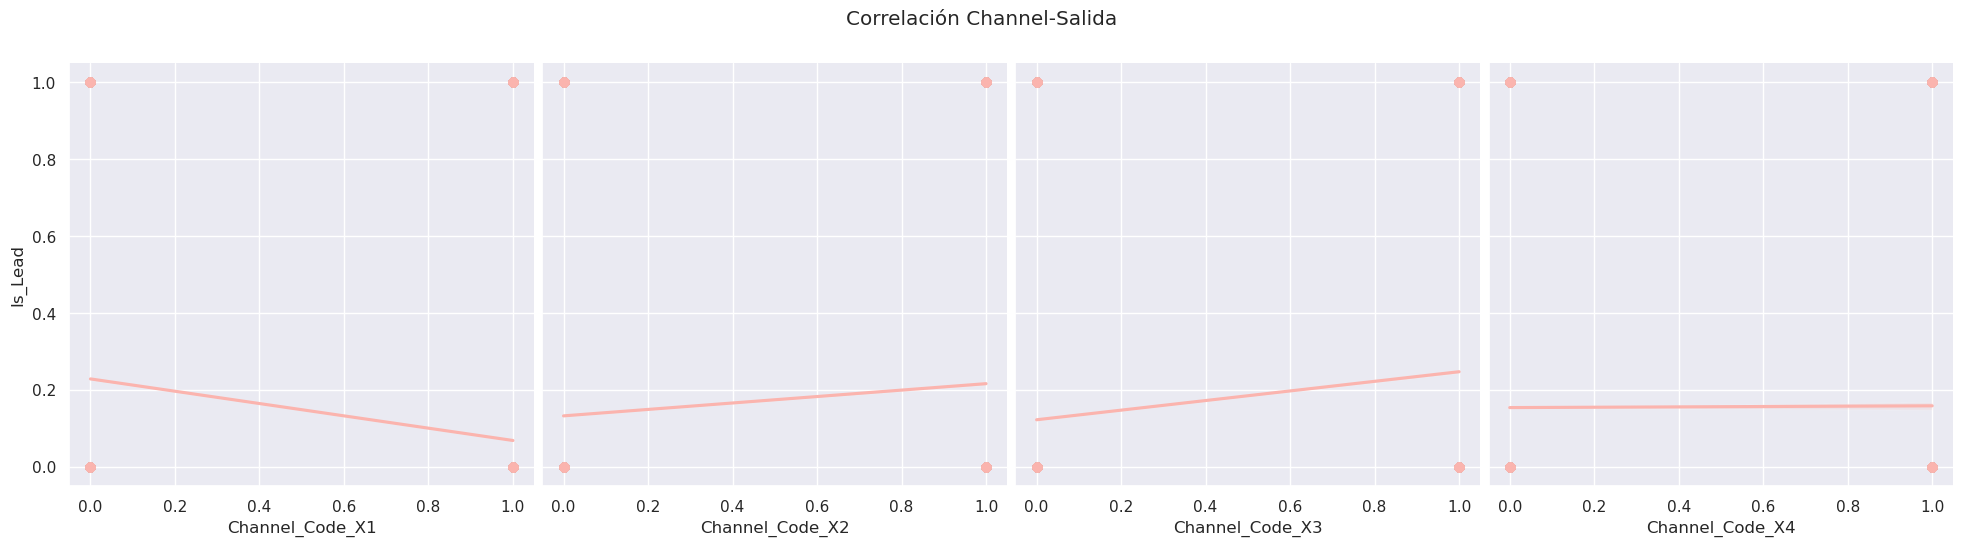

In [20]:
# Tratemos de ver correlación entre las variables de Channel_Code y la salida
x_vars = [ x for x in list(data) if 'Channel_Code' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Channel-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Parece que por lo menos las tres primeras sí tienen un efecto en la salida
# Aquí podría parecer que el chanel X4 es el menos efectivo obteniendo leads

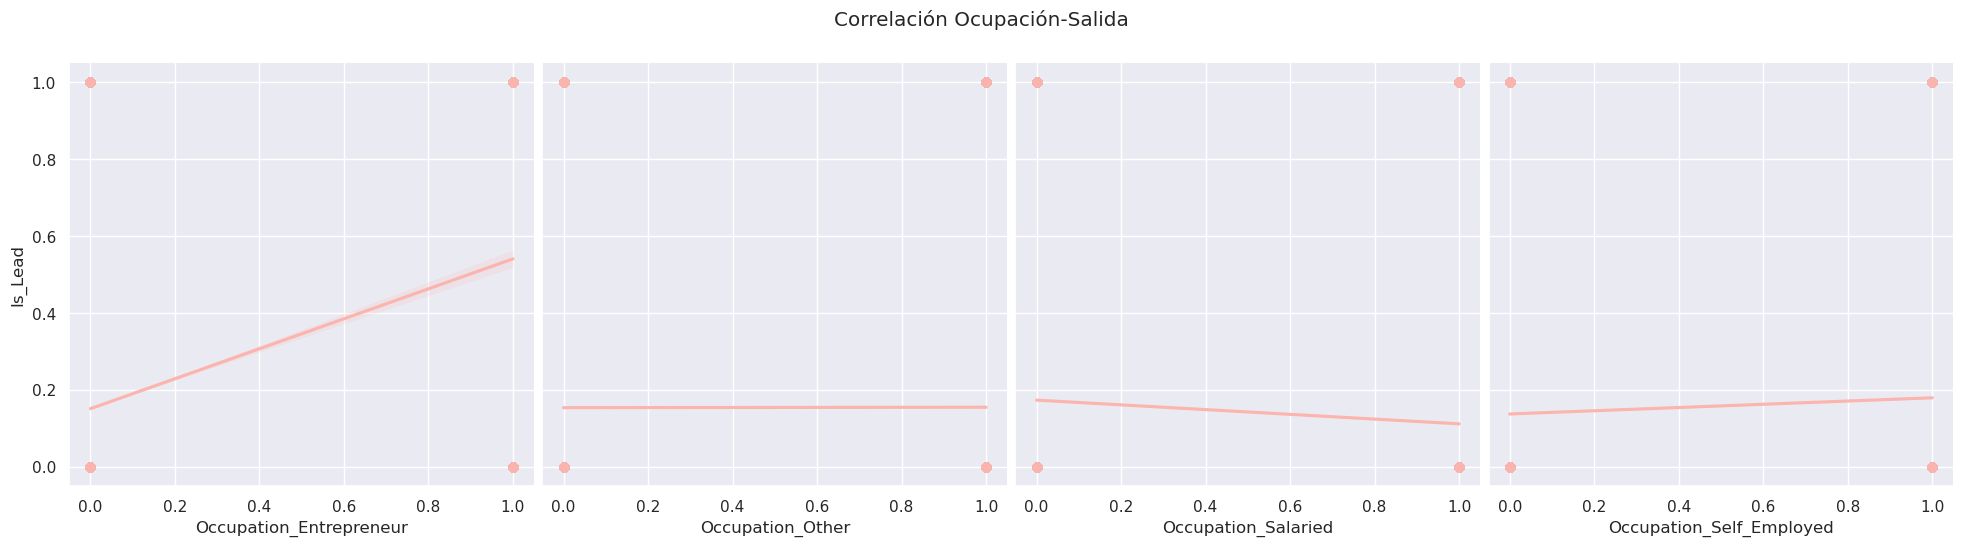

In [21]:
# Tratemos de ver correlación entre las variables de Occupation y la salida
x_vars = [ x for x in list(data) if 'Occupation' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Ocupación-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Vemos que de entre las 4, Occupation_Entrepreneur es la que tiene más efecto sobre la salida

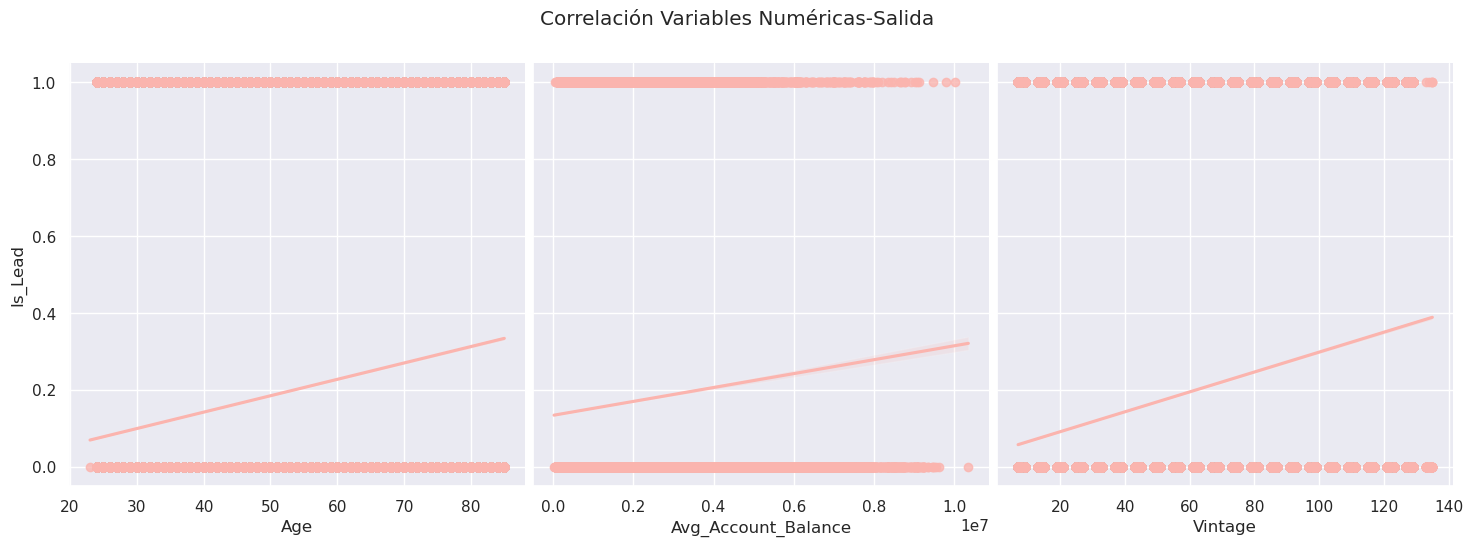

In [22]:
# Tratemos de ver correlación entre nuestras variables numéricas y la salida:
x_vars = ['Age','Avg_Account_Balance','Vintage'] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Variables Numéricas-Salida', y=1.08)
    plt.show()
    
# Observaciones:
# Vemos que de las tres tienen cierto grado apreciable de correlación con la salida

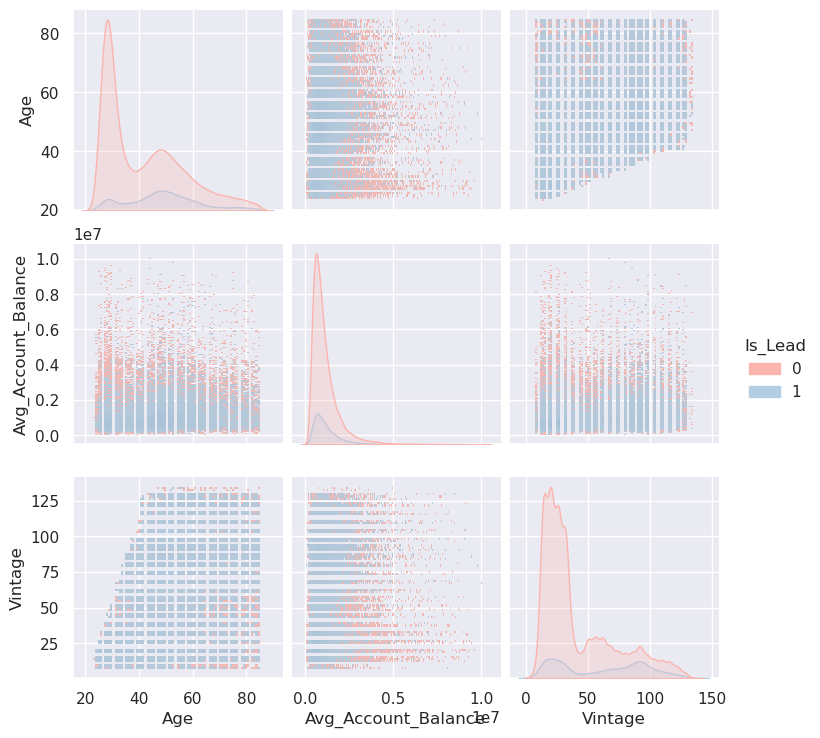

In [23]:
# Y ahora veamos la correclación entre esas tres variables
#sns.pairplot(data, vars=x_vars, hue='Is_Lead', markers = ['d','v'], kind = "hist", diag_kind = None)
if LONG_TIME_CELLS:
    sns.pairplot(data, vars=x_vars, hue='Is_Lead', kind = "hist", diag_kind = 'kde')

# Observaciones:
# No encotramos mucha correlación entre éstas

In [24]:
# También vemos la correlación entre estas variables usando Spearman
display(data[x_vars].corr(method="spearman"))

# Observaciones:
# Se observa una correlación significativa entre Age y Vintage, lo cual es de esperarse porque
# sólo la gente de mayor edad puede tener más historial crediticio
# (Yo esperaba encontrar más correlación entre edad y balance)

,Age,Avg_Account_Balance,Vintage
Age,1.000000,0.168859,0.655250
Avg_Account_Balance,0.168859,1.000000,0.184243
Vintage,0.655250,0.184243,1.000000


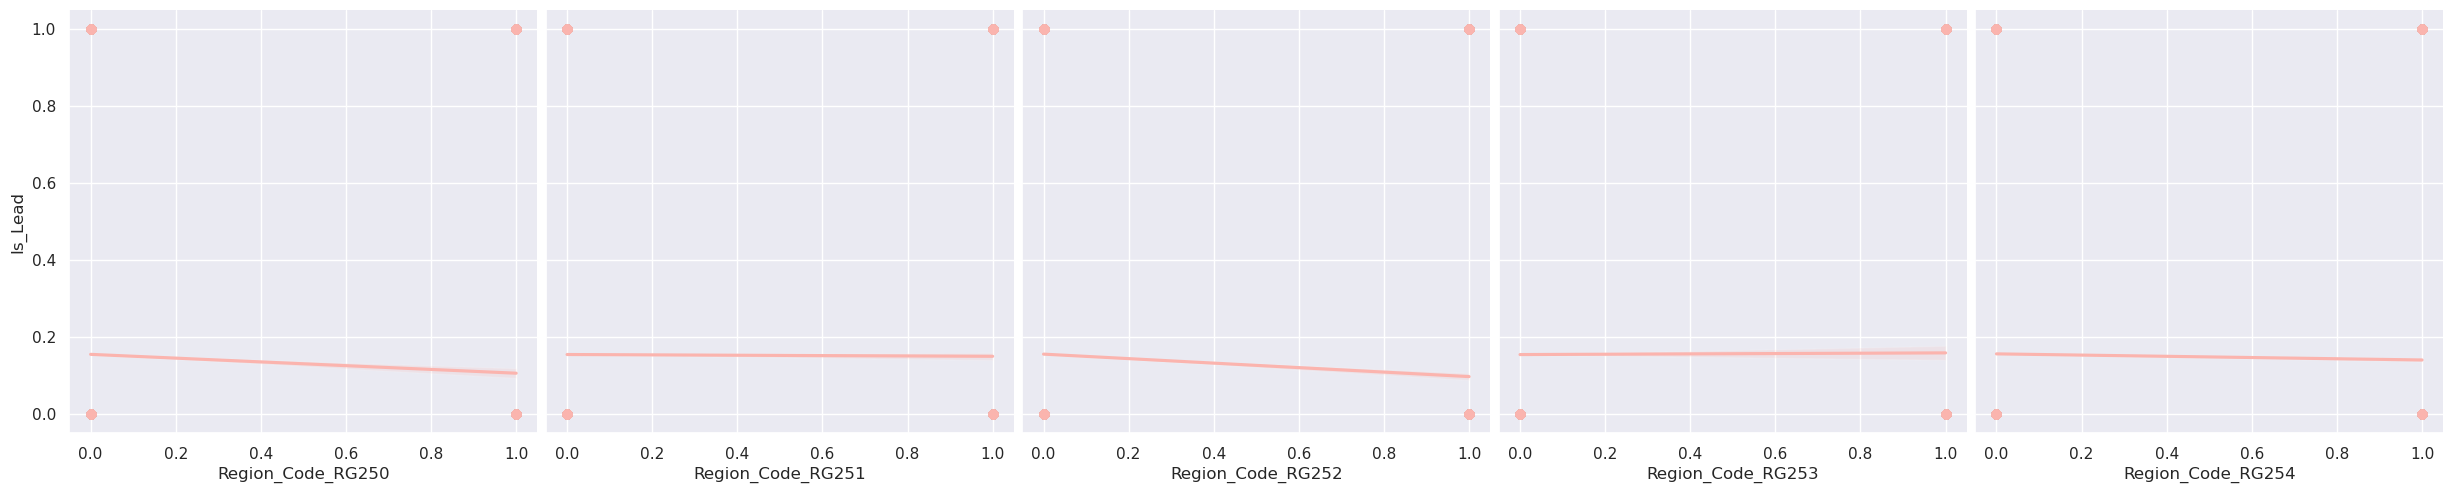

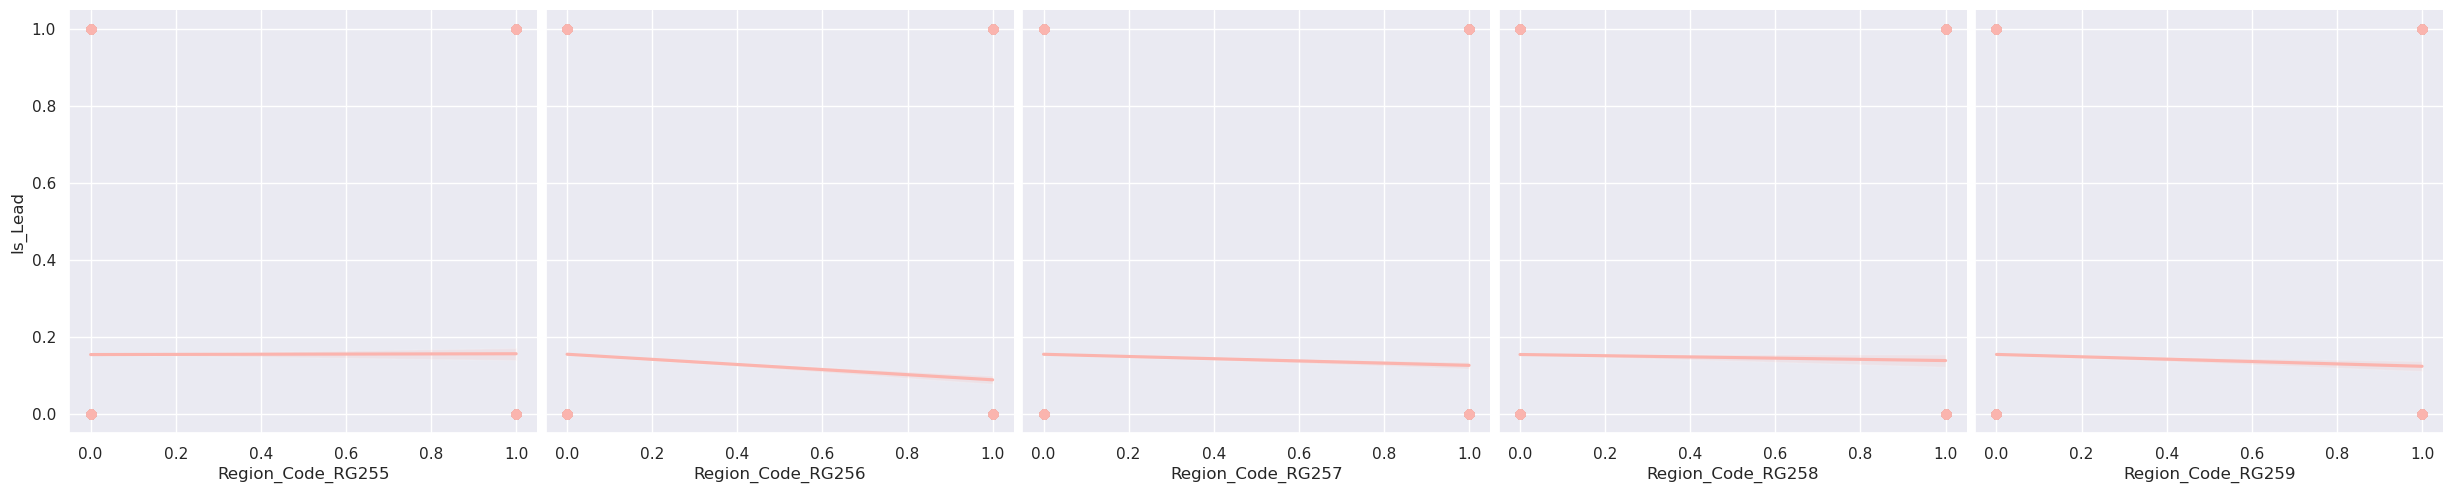

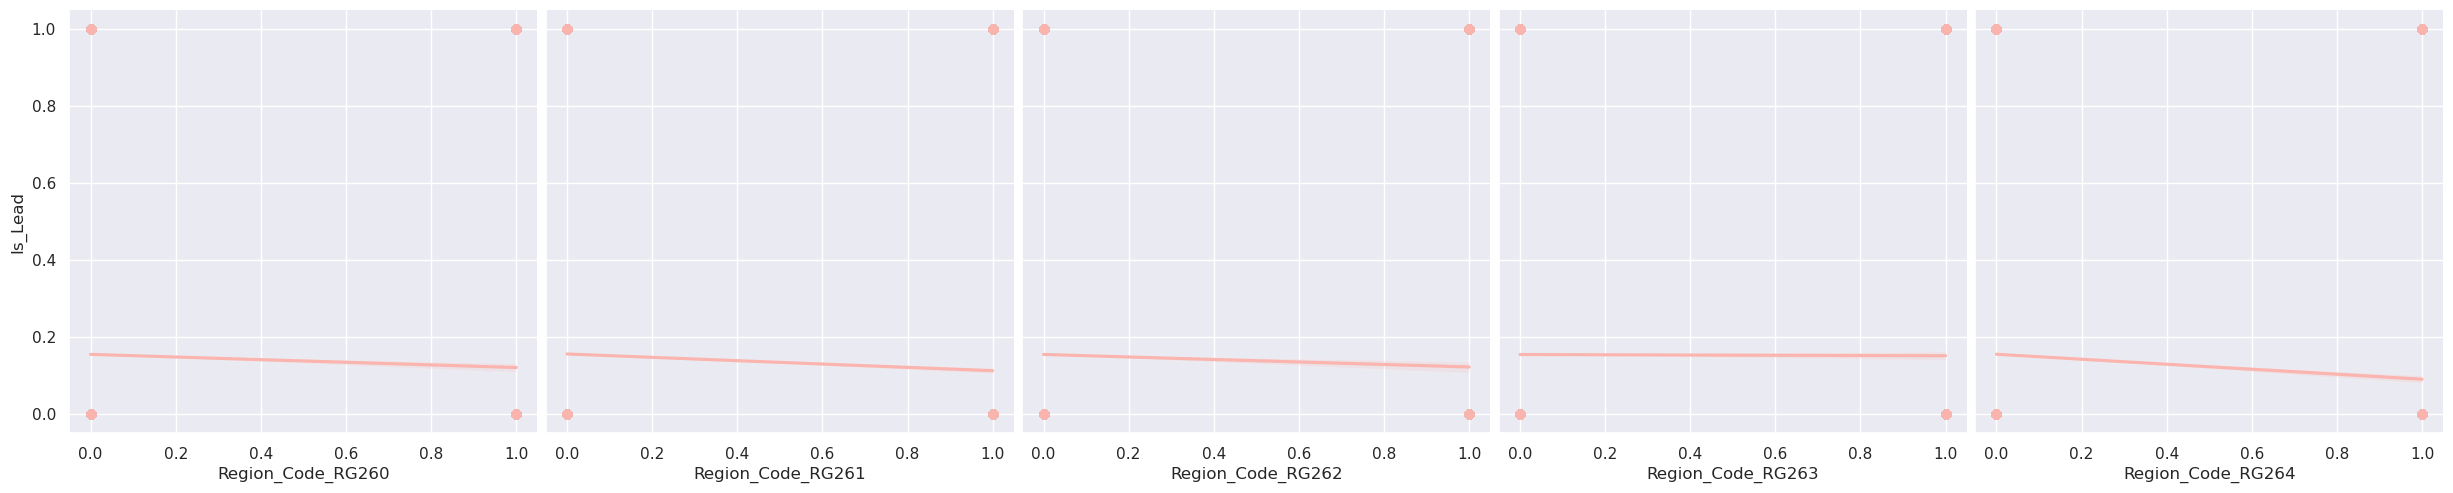

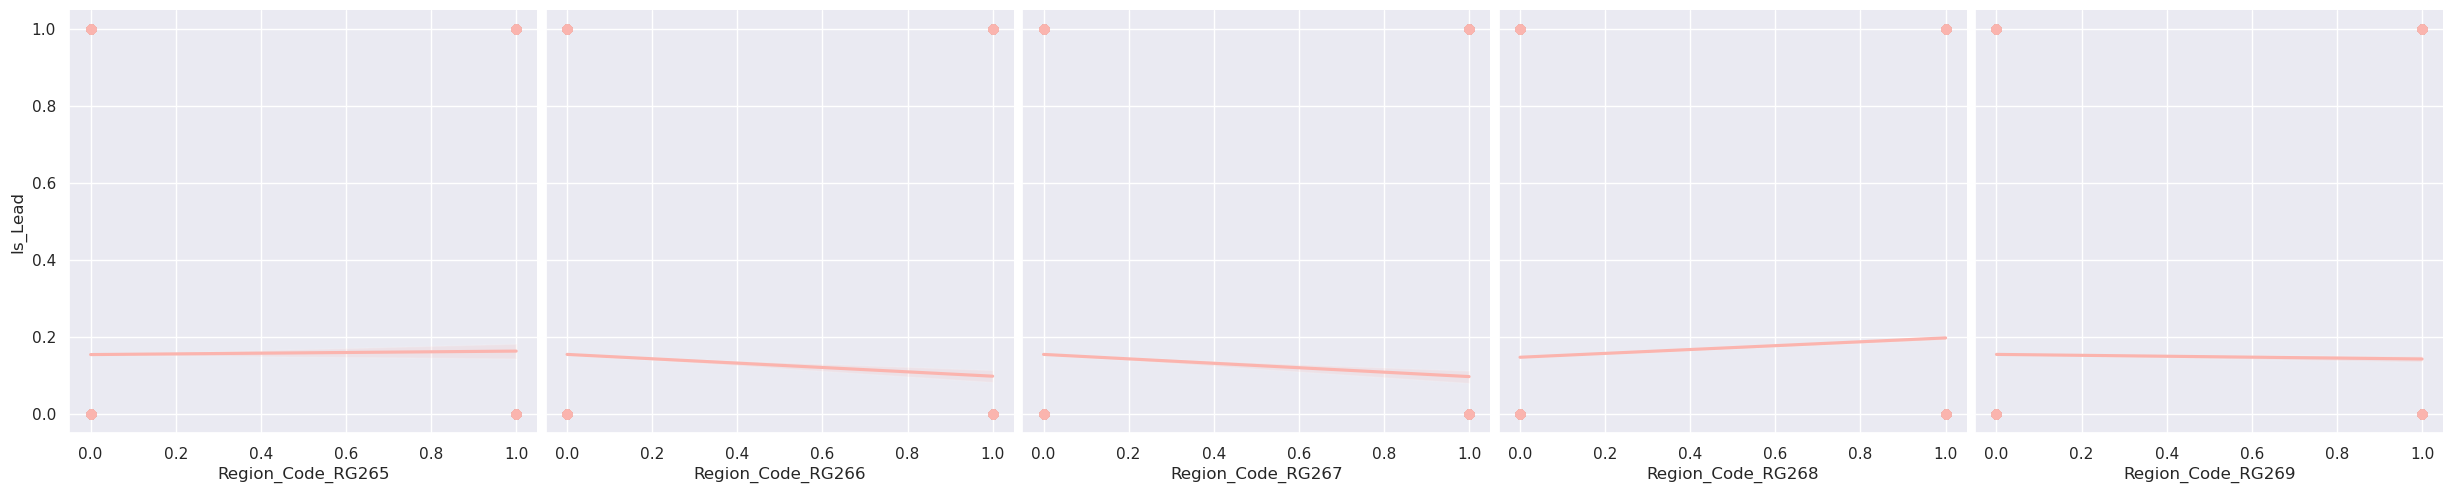

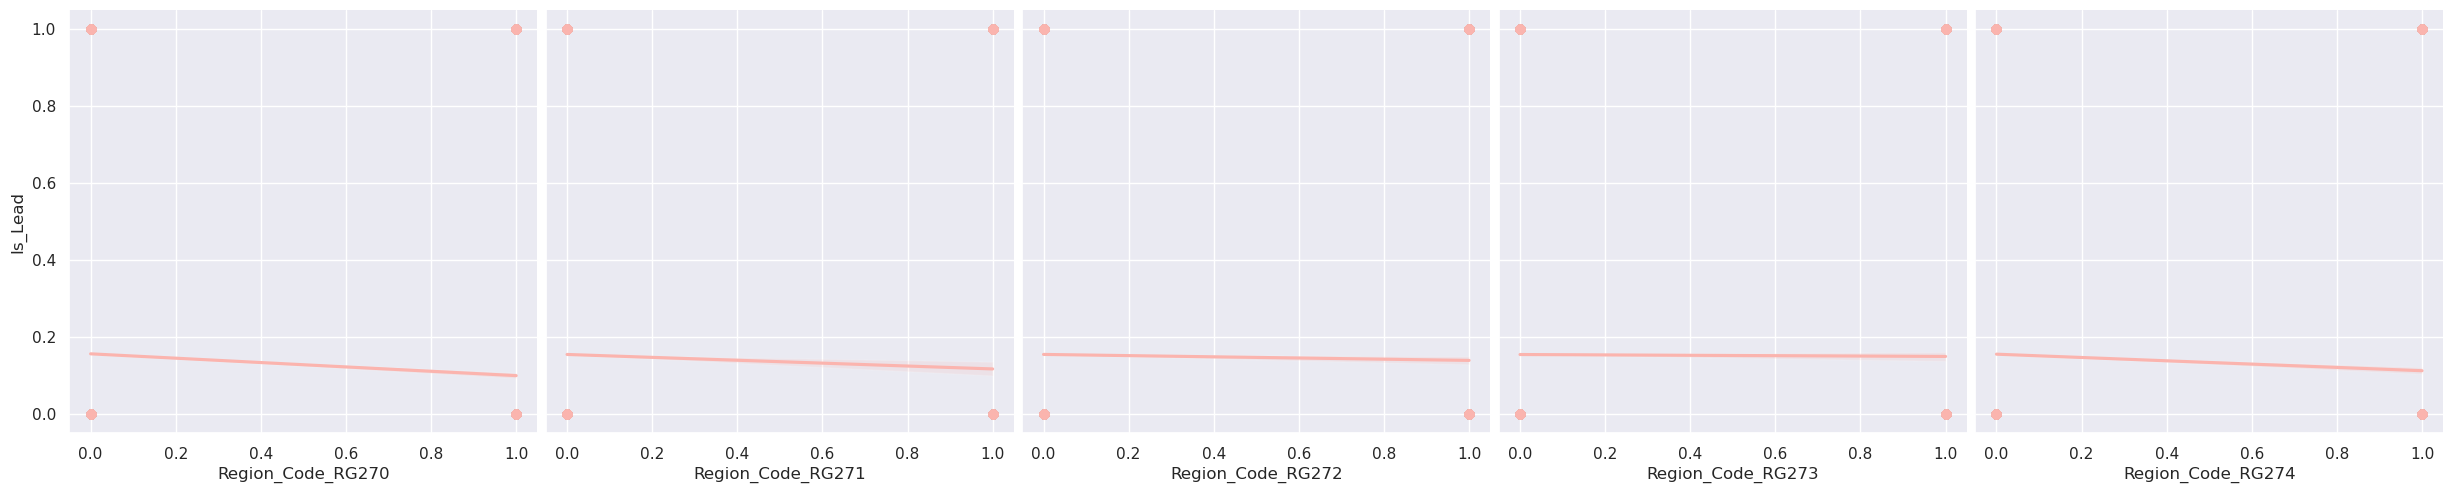

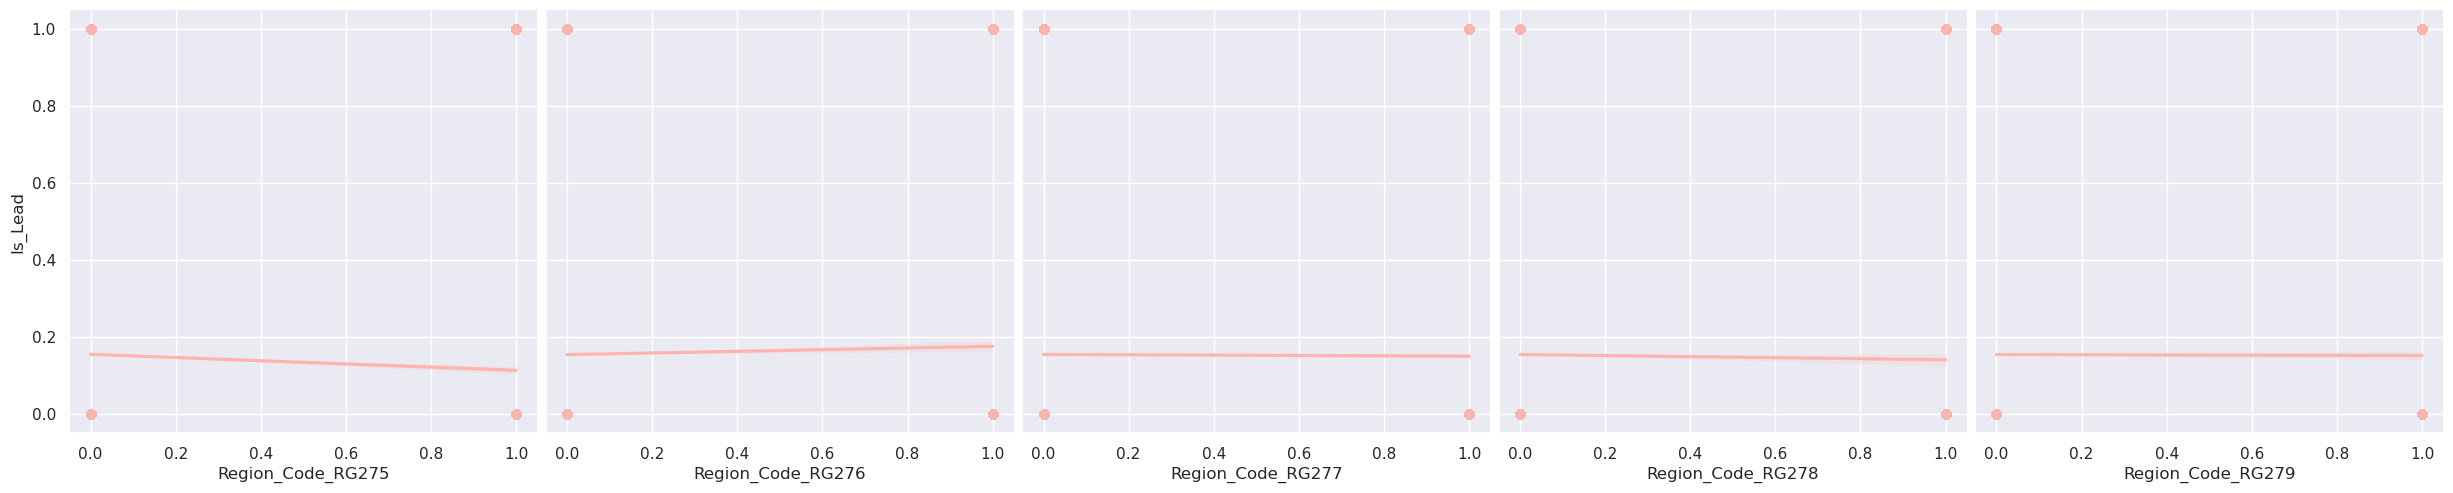

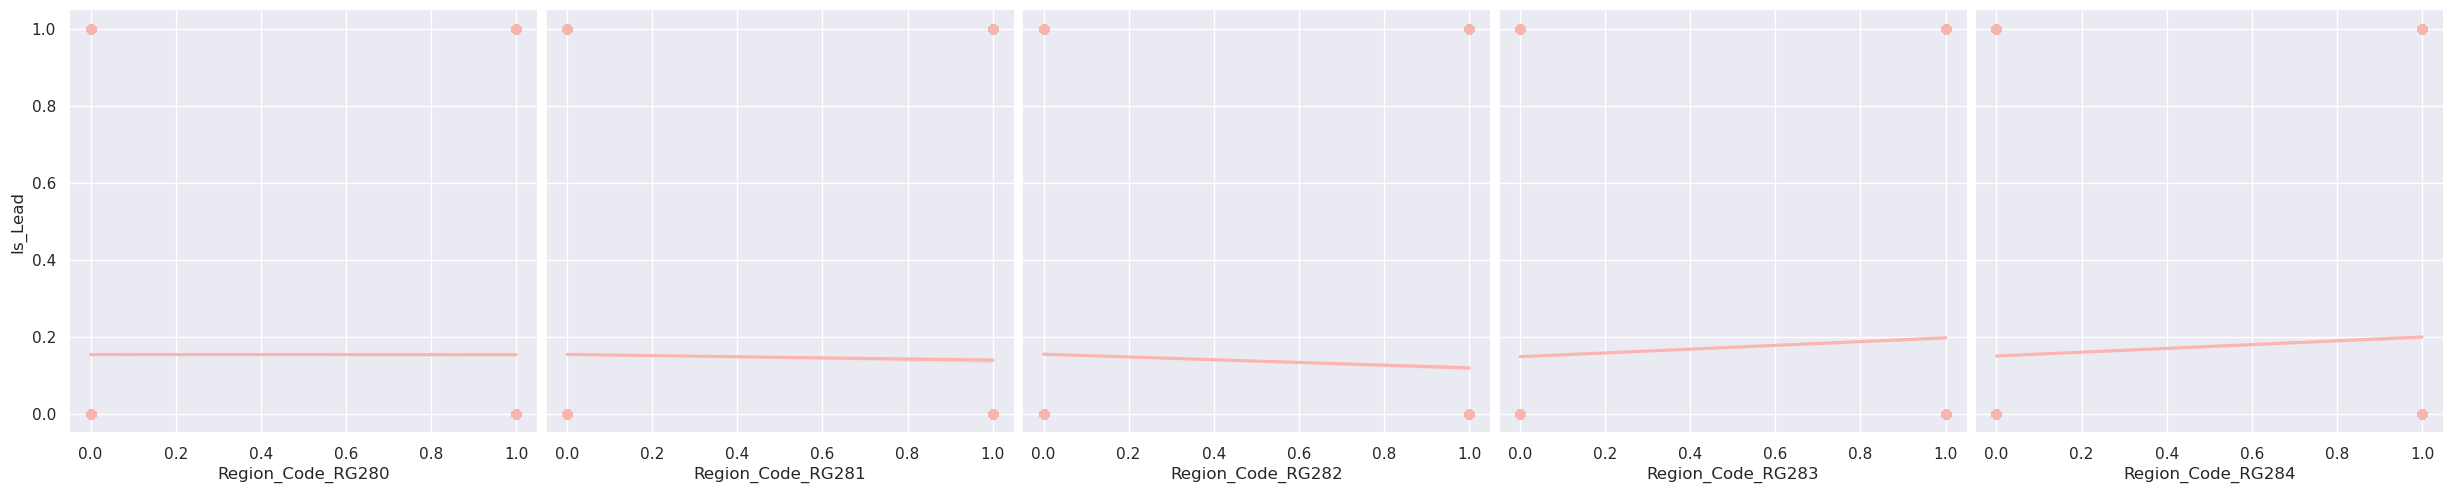

In [25]:
# Tratemos de ver correlaciones entre las variables de región y la salida
x_vars = list(data)
x_vars = [ x for x in x_vars if 'Region' in x] 

#print(x_vars)
#print(len(x_vars))

graphsPerRow = 5

assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'

if LONG_TIME_CELLS:
    for i in range(int(len(x_vars)/graphsPerRow)):
        sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        plt.show()

# Observaciones:
# No notamos que alguna región destaque

In [26]:
# Veamos si hay otras correlaciones entre nuestras variables:
thres = .4
corrs = data.corr(method="spearman")
print(f'Spearman > {thres}:')
print(f'-------------------------')
moreCorr = []
for i, row in corrs.iterrows():
    for ic,val in zip(list(data),row):
        if val>thres and i!=ic:
            if val>=.4 and val<.69:
                note = 'Moderate Correlation'
            elif val>.7 and val<.89:
                note = 'Strong Correlation'
            elif val>=.9:
                note = 'Very Strong Correlation'
                
            variablesCorrelacionadas = [i,ic]
            variablesCorrelacionadas.sort()
            text = ' - '.join(variablesCorrelacionadas)
            moreCorr.append(f' {text} : {str(round(val,3))} ({note})')

moreCorr=list(set(moreCorr))
moreCorr.sort()
for i in moreCorr:
    print(i)

Spearman > 0.4:
-------------------------
 Age - Channel_Code_X3 : 0.474 (Moderate Correlation)
 Age - Vintage : 0.655 (Moderate Correlation)
 Channel_Code_X1 - Occupation_Salaried : 0.603 (Moderate Correlation)
 Channel_Code_X3 - Vintage : 0.484 (Moderate Correlation)


### Observaciones:
Se nota una correlación moderada entre Channel_Code_X3 y  Vintage (pudo ser que ese canal se enfocó en ciertos clientes con mucha o poca antiguedad).

También moderada de ese mismo canal y la edad de los clientes.

Y correlaciones un poco más fuertes entre el canal X1 y clientes asalariados.

Desde luego, la correlación que ya habiamos notado entre edad y vintage (historial crediticio).

### Sampling para entrenar y copia de datos completos

In [ ]:
dataFull = data.copy()
X_full = dataFull.drop('Is_Lead',axis=1)
y_full = dataFull['Is_Lead']

In [82]:
# Ejecutar desde aquí para diferentes pruebas con fracciones de los datos originales
data = dataFull.sample(frac=DATA_FRACTION)
data.reset_index(inplace=True,drop=True)

print("Fracción de datos utlizados para entrenamiento:", DATA_FRACTION*100,'%')
print('Train Data size:',data.shape)
print('Full Data size:',dataFull.shape)

Fracción de datos utlizados para entrenamiento: 80.0 %
Train Data size: (13850, 50)
Full Data size: (17312, 50)


### Primer splitting para entrenar

In [83]:
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

## Selección de features con SelectKBest

In [84]:
# Selección de Features con Threshold fue descartada debido al alto número de variables categpóicas
best=10
selector = SelectKBest(k=best,score_func=chi2)

#scaler = MinMaxScaler()
#XScaled = scaler.fit_transform(X)
#XScaled = pd.DataFrame(data=XScaled, columns=list(X))

selector.fit(X,y)
print(f'Las {best} mejores features son:')
for col in selector.get_feature_names_out():
    print(f'   {col}')


Las 10 mejores features son:
   Age
   Vintage
   Avg_Account_Balance
   Occupation_Entrepreneur
   Occupation_Salaried
   Is_Active_Yes
   Credit_Product_Yes
   Channel_Code_X1
   Channel_Code_X2
   Channel_Code_X3


**Observaciones:**

Las 3 variables numéricas son las más importantes de acuerdo al selector. También confirmamos que de las variables categóricas, Occupation_Entrepreneur juega el papel más importante importante.

## Árboles de decisión

### Arboles de decisión con datos originales (1/3)

In [85]:
# dataframe para guardar performace metrics
treesPerformances = pd.DataFrame(columns=['Data', 'Acc','Recall','Precision', 'F1'])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [87]:
# guardemos X_test y_test originales para usarlos en los dos árboles finales:
X_test_original = X_test.copy()
y_test_original = y_test.copy()

In [88]:
importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

,importancia
feature,
Avg_Account_Balance,0.230
Vintage,0.165
Age,0.161
Credit_Product_Yes,0.107
Is_Active_Yes,0.030
Occupation_Salaried,0.029
Gender_Male,0.022
Channel_Code_X2,0.018
Region_Code_RG254,0.018


Accuracy: 0.787
Recall: 0.367
Precision: 0.321


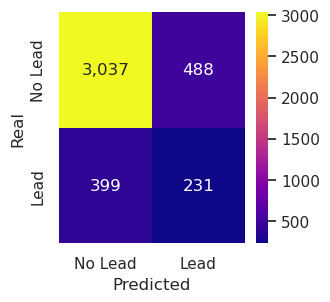

In [89]:
pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Datos originales', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()

**Observaciones:**
    
Al parecer el hecho de que los ejemplos están desbalanceados affecta el desempeño del modelo. A continuación balancearemos los ejemplos por medio de sub/over sampling.


### Árboles de decisión con datos submuestreados  (1/2)

In [90]:
import imblearn

#Submuestreo

# lista los índices de Is_Lead
lead_idxs = data[data["Is_Lead"]==1].index.to_list()
print('Is_Lead == 1: ',len(lead_idxs))

# lista de índices que no son lead
nolead_idxs = data[data["Is_Lead"]==0].index.to_list()
print('Is_Lead == 0: ',len(nolead_idxs))

# seleccionamos aleatoriamente el doble de índices de no leads
random_nolead_idxs = np.random.choice(nolead_idxs, int(len(lead_idxs)*1.0), replace= False)
print('random picks len:',len(random_nolead_idxs))

# concatenamos los índices fraudulentos y normales y creamos el dataframe sub-sampleado
undersampled_indices = np.concatenate([lead_idxs, random_nolead_idxs])
undersampled_data = data.iloc[undersampled_indices,:]

print(f"Lead: {len(lead_idxs)}, Normales: {len(random_nolead_idxs)}")

print(f'Tamaño de data sin resampling: {data.shape}')
print(f'Tamaño de data luego de resampling: {undersampled_data.shape}')

Is_Lead == 1:  2061
Is_Lead == 0:  11789
random picks len: 2061
Lead: 2061, Normales: 2061
Tamaño de data sin resampling: (13850, 50)
Tamaño de data luego de resampling: (4122, 50)


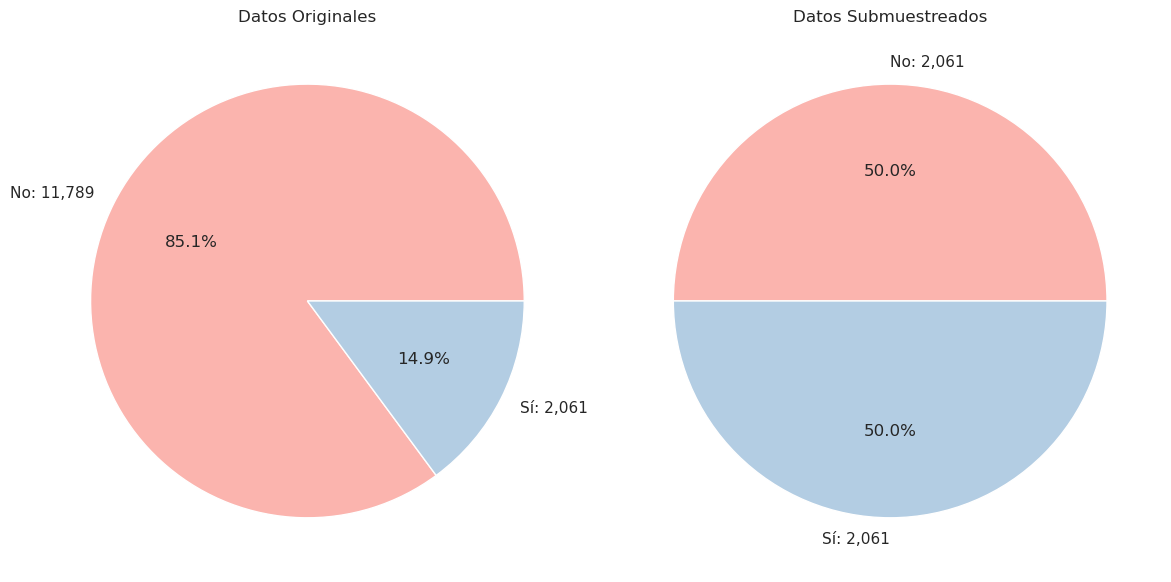

In [91]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

create_piechart_with_values(data.Is_Lead, 'Datos Originales',ax1,['No','Sí'])    
create_piechart_with_values(undersampled_data.Is_Lead, 'Datos Submuestreados',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()

In [92]:
# "backup de data"
dataBkup = data.copy()

,importancia
feature,
Avg_Account_Balance,0.200
Credit_Product_Yes,0.170
Age,0.156
Vintage,0.154
Gender_Male,0.036
Is_Active_Yes,0.024
Region_Code_RG254,0.017
Region_Code_RG283,0.016
Region_Code_RG277,0.015


Accuracy: 0.619
Recall: 0.597
Precision: 0.624


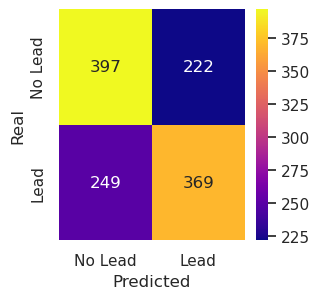

In [93]:
X = undersampled_data.drop('Is_Lead',axis=1)
y = undersampled_data['Is_Lead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
# no guardamos en df para metricas (haremos otro test con los datos originales, no los submuestreados)
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



,importancia
feature,
Avg_Account_Balance,0.200
Credit_Product_Yes,0.170
Age,0.156
Vintage,0.154
Gender_Male,0.036
Is_Active_Yes,0.024
Region_Code_RG254,0.017
Region_Code_RG283,0.016
Region_Code_RG277,0.015


Accuracy: 0.717
Recall: 0.883
Precision: 0.336


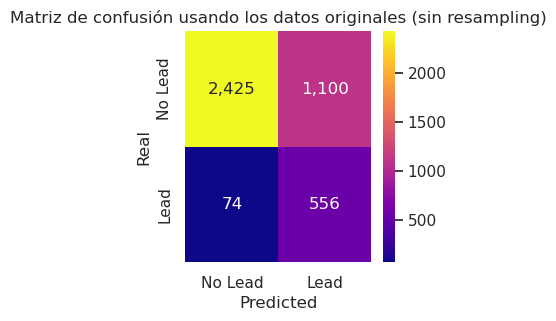

In [94]:
# test con los datos de prueba originales:
y_pred = clf.predict(X_test_original)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test_original, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Sub-muestreo', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_original,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.title('Matriz de confusión usando los datos originales (sin resampling)')    
plt.show()

### Árboles de decisión con oversampling  (3/3)

In [95]:
# restauramos data
data=dataBkup.copy()

X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

print(data.shape)

oversample = SMOTE()
X_oversampled, y_oversampled = oversample.fit_resample(X, y)

print(f"Matriz de features: {X_oversampled.shape}")
print(f"Matriz de etiquetas: {y_oversampled.shape}")

from collections import Counter
print(Counter(y_oversampled))

(13850, 50)
Matriz de features: (23578, 49)
Matriz de etiquetas: (23578,)
Counter({0: 11789, 1: 11789})


,importancia
feature,
Channel_Code_X1,0.227
Occupation_Other,0.125
Avg_Account_Balance,0.122
Occupation_Self_Employed,0.096
Vintage,0.090
Age,0.072
Channel_Code_X2,0.043
Channel_Code_X3,0.043
Credit_Product_Yes,0.029


Accuracy: 0.852
Recall: 0.863
Precision: 0.848


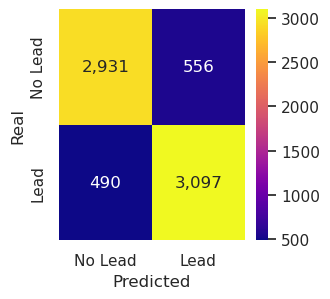

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
# no guardamos en df de metricas, más adelante probaremos con los datos originales, no los sobremuestreados
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



In [97]:
viz = model(clf,
        tree_index=3,
        X_train=X_train,
        y_train=y_train,
        feature_names=list(X_train),
        target_name='Lead',
        class_names=['Lead','No Lead']
)

if LONG_TIME_CELLS:
    # no funciona
    # viz.view(scale=1.2,fontname='DejaVu Sans')
    pass


In [98]:
text_representation = tree.export_text(decision_tree=clf)
print(X_train.columns[9])
print(text_representation)


Credit_Product_Yes
|--- feature_10 <= 0.50
|   |--- feature_7 <= 0.50
|   |   |--- feature_5 <= 0.50
|   |   |   |--- feature_6 <= 0.50
|   |   |   |   |--- feature_4 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_4 >  0.50
|   |   |   |   |   |--- feature_13 <= 0.50
|   |   |   |   |   |   |--- feature_1 <= 62.00
|   |   |   |   |   |   |   |--- feature_47 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_27 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_44 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_1 <= 38.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_1 >  38.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- feature_44 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_27 >  0.50
|   |   |   |   |   |   |   |   |   |---

In [99]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(X),class_names=['No Lead','Lead'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('cardleads-tree.png')
#Image(graph.create_png())

,importancia
feature,
Channel_Code_X1,0.227
Occupation_Other,0.125
Avg_Account_Balance,0.122
Occupation_Self_Employed,0.096
Vintage,0.090
Age,0.072
Channel_Code_X2,0.043
Channel_Code_X3,0.043
Credit_Product_Yes,0.029


Accuracy: 0.937
Recall: 0.832
Precision: 0.769


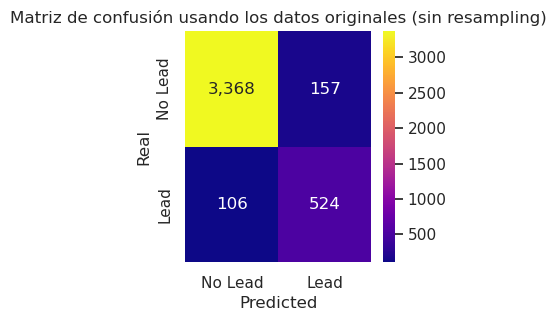

In [100]:
# test con los datos de prueba originales:
y_pred = clf.predict(X_test_original)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test_original, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Sobre-muestreo', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_original,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.title('Matriz de confusión usando los datos originales (sin resampling)')    
plt.show()

### Comparación de métricas de rendimiento para los árboles de decisión usando diferentes datos

In [101]:
display(treesPerformances.sort_values(by='Acc', ascending=False))

,Data,Acc,Recall,Precision,F1
2,Sobre-muestreo,0.937,0.832,0.769,0.799
0,Datos originales,0.787,0.367,0.321,0.342
1,Sub-muestreo,0.717,0.883,0.336,0.486


## Búsqueda de componentes pricipales

Train data luego de reducción de dimensionalidad: (13850, 49)
Train data luego de reducción de dimensionalidad: (13850, 25)
El 70.0% de la varianza se obtiene con 7 componentes principales



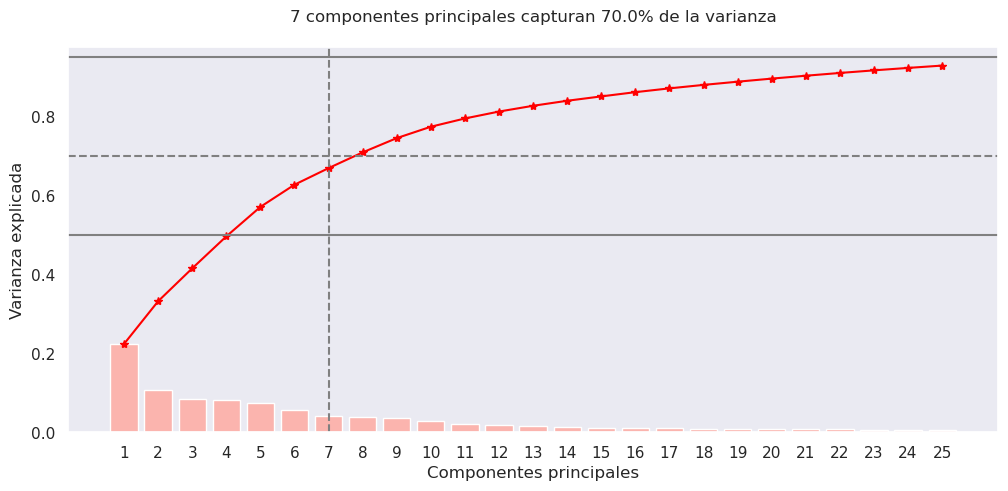

In [102]:
# restauramos data
data=dataBkup.copy()
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=25)
X_red = pca.fit_transform(X_scaled)
#X_challenge_red = pca.transform(X_challenge_scaled)

print('Train data luego de reducción de dimensionalidad:',X.shape)
print('Train data luego de reducción de dimensionalidad:',X_red.shape)
#print('Test data luego de reducción de dimensionalidad:',X_challenge_red.shape)

xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))
capturedVarThreshold = .70

plt.figure(figsize=(12,5))
plt.bar(xs, pca.explained_variance_ratio_)
plt.xticks(xs)
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), '-*',color='red')
plt.grid()
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")

captured = np.cumsum(pca.explained_variance_ratio_)
#print(f"Varianza explicada por cada una de las componentes principales:\n{pca.explained_variance_ratio_}\n")
#print(f"Varianza acumulada explicada por cada una de las componentes principales:\n{captured)}\n")

plt.axhline(.5,color='gray',linestyle='-')
plt.axhline(.95,color='gray',linestyle='-')

maxPC = np.where(captured >= capturedVarThreshold)[0][0]
plt.axhline(capturedVarThreshold,color='gray',linestyle='--')
plt.axvline(maxPC,color='gray',linestyle='--')
#plt.xticks(rotation=80)

plt.title(f"{maxPC} componentes principales capturan {capturedVarThreshold*100}% de la varianza\n")

print(f"El {capturedVarThreshold*100}% de la varianza se obtiene con {maxPC} componentes principales\n")

### Preparación de pipeline y grid search para prueba de múltiples clasificadores con múltiples hiperparámetros

Usaremos los datos submuestreados ~~sobremuestreados~~.

In [103]:
DATA_TO_USE = 'sub' # 'over' | 'sub' | 'orig'

if DATA_TO_USE == 'over':
    X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3, random_state=101) # 70% training and 30% test
elif DATA_TO_USE == 'sub':
    X = undersampled_data.drop('Is_Lead',axis=1)
    y = undersampled_data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test
elif DATA_TO_USE == 'orig':
    data = dataBkup.copy()
    X = data.drop('Is_Lead',axis=1)
    y = data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

print(f"Usando data: {DATA_TO_USE}")    
print(f"Matriz de features: {X.shape}")
print(f"Matriz de etiquetas: {y.shape}")

Usando data: sub
Matriz de features: (4122, 49)
Matriz de etiquetas: (4122,)


In [104]:
# dataframe para guardar performace metrics
classifiersPerformances = pd.DataFrame(columns=['Classifier',
                                                'Train Acc','Test Acc','Train Orig Acc',
                                                'Train Recall','Test Recall','Test Orig Recall',
                                                'Train Precision','Test Precision','Test Orig Precision',
                                                'Train F1','Test F1','Test Orig F1',
                                               ])

classifiersPerformances = pd.DataFrame(columns=['Classifier','Data',
                                                'Acc','Recall','Precision','F1',
                                               ])

In [105]:
SCALER = True
POLY = False
DIMRED = True # si no hacemos dimRed el fitting toma demasiado tiempo
PCA_COMPONENTS = maxPC # que quedó en 11

# CLASSIFIER /////////////////////(editar para cambiar el clasificador)/////////////////////
#classifier = RandomForestClassifier(n_jobs=-1)
classifier = SVC()
#classifier =  RidgeClassifier()

# SCALER OBJECT
scaler = MinMaxScaler() if SCALER else None
#scaler = StandardScaler()

# POLYNOMIAL FEATURES OBJECT
poly = PolynomialFeatures(include_bias=True) if POLY else None

# DIMENSIONALITY REDUCTION OBJECT
dimRed = PCA(n_components=PCA_COMPONENTS) if DIMRED else None

# parámetros a probar con grid search:

# params for SVM:
#if type(classifier) == type(SVC()):
#    gridParams = [
#        {
#            'classifier__C': [.01,.1, 1, 10, 100, 1000],
#            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#            'classifier__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#            'poly__degree': [1,2,3]
#        },
#    ]
    

# Larger C values (e.g., 1, 10, 100) can be useful when:
#  The dataset is clean and has limited noise.
#  You want to capture complex decision boundaries.
#  You are willing to tolerate some misclassifications.

# Smaller gamma values (e.g., 0.001, 0.01) can be useful when:
#  The dataset is large.
#  The decision boundary is expected to be relatively smooth.
#  The classes are well-separated and the data is not too complex.

# params for SVM:
if type(classifier) == type(SVC()):
    gridParams = [
        {
            'classifier__C': [5, 10, 50],
            'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
            'classifier__gamma': [.001,0.1, 0.5],
            'poly__degree': [1,3]
        },
    ]

# params for RandomForest:
if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    gridParams = [
        {
            'classifier__n_estimators':[10,50,100]
        }]
    
# params for Linear(Ridge):
if type(classifier) == type(RidgeClassifier()):
    gridParams = [{
        'classifier__alpha':[.01,.1, 1,5,10],
    }]

# quitamos los parámetros que no se utilizarán
newParams = []
for d in gridParams:
    td = d.copy()
    for k in d.keys():
        if 'scaler' in k and not SCALER: del(td[k])
        if 'poly' in k and not POLY: del(td[k])
        if 'dimRed' in k and not DIMRED: del(td[k])
    newParams.append(td)
gridParams = newParams
            
# definimos los pasos del pipeline
steps=[
    ('scaler',scaler if scaler else 'passthrough'),
    ('dimRed', dimRed if dimRed else 'passthrough'),
    ('poly',poly if poly else 'passthrough'),
    ('classifier',classifier)
]

# quitamos del pipeline los pasos que no utilizaremos
steps = [s for s in steps if s[1]!='passthrough']
pipe = Pipeline(steps=steps)

# instanciamos un objeto de GridSearchCV
grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = gridParams,
    scoring = 'accuracy',
    cv = 5, # incluimos cross validations en el grid search
    n_jobs = -1,
)

print('Steps to run:')
for s in [str(step) for step in pipe.steps]: print('\t',s)


Steps to run:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC())


In [106]:
# fit the model and time it
start_time = time.time()
print('inicio:',time.asctime())
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()
duration = end_time - start_time
print('fin:',time.asctime())
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print('Datos usados:',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

inicio: Wed Jun  7 01:56:16 2023
fin: Wed Jun  7 01:56:20 2023
Tiempo para fit operations: 0.06 minutos
Datos usados: sub
X_train: 2,885, X_test: 1,237, y_train: 2,885, y_test: 1,237


### Mejor estimador

Fracción de datos utlizados para set inicial de entrenamiento: 80.0 %

Datos usados para entrenamiento (originales, subsampled, oversampled): sub
X_train: 2,885, X_test: 1,237, y_train: 2,885, y_test: 1,237

Tiempo para fit operations: 0.06 minutos

Componentes principales utlizados 7 (70.0% de la varianza)

Mejor accuracy gridSearch: 0.7248

Hiperparámetros del mejor modelo de gridsearch:
{'classifier__C': 50, 'classifier__gamma': 0.5, 'classifier__kernel': 'poly'}

Pasos del pipeline:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC())



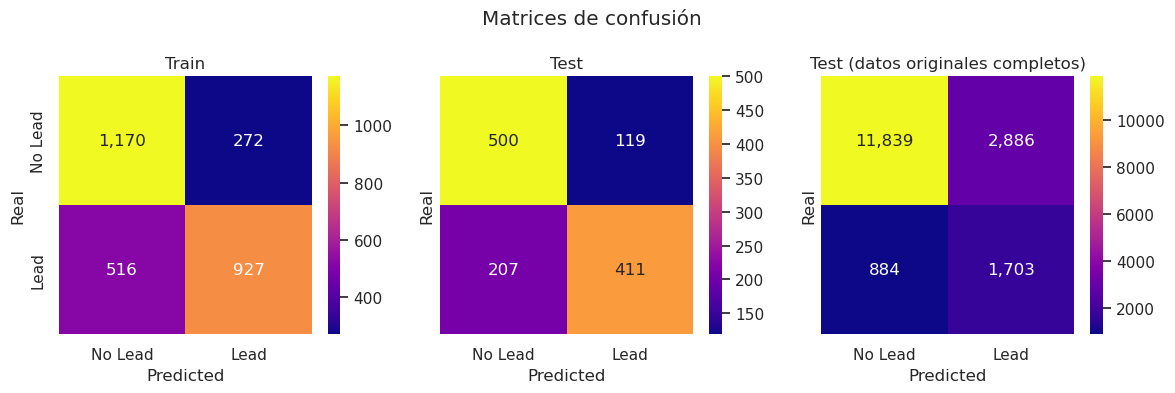

,Classifier,Data,Acc,Recall,Precision,F1
0,<class 'sklearn.svm._classes.SVC'>,Train,0.727,0.642,0.773,0.702
1,<class 'sklearn.svm._classes.SVC'>,Test,0.736,0.665,0.775,0.716
2,<class 'sklearn.svm._classes.SVC'>,Test Full,0.782,0.658,0.371,0.475


In [107]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Fracción de datos utlizados para set inicial de entrenamiento:", DATA_FRACTION*100,'%')
print()
print('Datos usados para entrenamiento (originales, subsampled, oversampled):',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))
print()
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print()
print("Componentes principales utlizados",maxPC,f'({capturedVarThreshold*100}% de la varianza)')
print()
print("Mejor accuracy gridSearch:", round(best_accuracy,4))
print()
print("Hiperparámetros del mejor modelo de gridsearch:")
print(best_parameters)
print()
print('Pasos del pipeline:')
for s in [str(step) for step in pipe.steps]: print('\t',s)
print()

# creamos un figura con tres subplots (train, test, test original)
target_labels = ['No Lead','Lead']
fig, axes = plt.subplots(1, 3, figsize=(12, 4),sharey=True)

# train
y_pred = best_model.predict(X_train)
pmScoreTrain=round(best_model.score(X_train,y_train),3)
pmAccuracyTrain=round(accuracy_score(y_train,y_pred),3)
pmRecallTrain=round(recall_score(y_train,y_pred),3)
pmPrecisionTrain=round(precision_score(y_train,y_pred),3)
pmF1Train=round(f1_score(y_train,y_pred),3)

cm = confusion_matrix(y_train,y_pred)
ax=axes[0]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Train')

    
    
# test
y_pred = best_model.predict(X_test)
pmScoreTest=round(best_model.score(X_test,y_test),3)
pmAccuracyTest=round(accuracy_score(y_test,y_pred),3)
pmRecallTest=round(recall_score(y_test,y_pred),3)
pmPrecisionTest=round(precision_score(y_test,y_pred),3)
pmF1Test=round(f1_score(y_test,y_pred),3)

cm = confusion_matrix(y_test,y_pred)
ax=axes[1]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test')




# test con los datos de prueba originales:
#y_pred = best_model.predict(X_test_original)
y_pred = best_model.predict(X_full)
#pmScoreTestOrig=round(best_model.score(X_test_original,y_pred),3)
pmScoreTestOrig=round(best_model.score(X_full,y_full),3)
#pmAccuracyTestOrig=round(accuracy_score(y_test_original,y_pred),3)
pmAccuracyTestOrig=round(accuracy_score(y_full,y_pred),3)
#pmRecallTestOrig=round(recall_score(y_test_original,y_pred),3)
pmRecallTestOrig=round(recall_score(y_full,y_pred),3)
#pmPrecisionTestOrig=round(precision_score(y_test_original,y_pred),3)
pmPrecisionTestOrig=round(precision_score(y_full,y_pred),3)
#pmF1TestOrig=round(f1_score(y_test_original, y_pred),3)
pmF1TestOrig=round(f1_score(y_full, y_pred),3)

#cm = confusion_matrix(y_test_original,y_pred)
cm = confusion_matrix(y_full,y_pred)
ax=axes[2]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test (datos originales completos)')

plt.suptitle('Matrices de confusión')
plt.tight_layout()
plt.show()

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Train',
                                                                  pmAccuracyTrain, pmRecallTrain, pmPrecisionTrain, pmF1Train
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test',
                                                                  pmAccuracyTest, pmRecallTest, pmPrecisionTest, pmF1Test
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test Full',
                                                                  pmAccuracyTestOrig, pmRecallTestOrig, pmPrecisionTestOrig, pmF1TestOrig
                                                                  ] 

display(classifiersPerformances)

if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    if SCALER:
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = X_train_scaled
        
    if DIMRED:
        pca = PCA(n_components=maxPC)
        X_train_red = pca.fit_transform(X_train)
        X_train = X_train_red
    
    feature_cols = pd.DataFrame(X_train_red).columns.to_list()
    classifier.fit(X_train,y_train)
    
    importances = pd.DataFrame({'feature':feature_cols,'importancia':np.round(classifier.feature_importances_,3)})
    importances.sort_values(by='importancia',ascending=False,inplace=True)
    importances.set_index('feature')
    print(importances)



### Clustering para ver clientes parecidos y su clase